In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
df = pd.read_csv('df_interpolated (1).csv')  # Update with your dataset path
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y').dt.strftime('%m/%d/%Y')
#df['date'] = pd.to_datetime(df['date'])

# Select relevant columns
columns = ['date', 'gold_price_usd', 'silver_price', 's&p_500_index','nyse_com_index', 'usd_selling_exrate']
data = df[columns].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define window size for LSTM
window_size = 30

# Create sequences
X, y = [], []
for i in range(window_size, len(data)):
    X.append(scaled_data[i-window_size:i, :])
    y.append(scaled_data[i, -1])  # gold_price_yahoo is the last column

X, y = np.array(X), np.array(y)

# Split data into train and test sets
split = int(0.8 * len(data))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=1)

# Make predictions
predictions = model.predict(X_test)

# Inverse scaling for predictions and actual values
predictions = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], predictions), axis=1))[:, -1]
actual_values = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_test.reshape(-1, 1)), axis=1))[:, -1]

# Generate future dates
last_date = df['date'].iloc[-1]
future_dates = pd.date_range(start=last_date, end='2024-09-10', freq='B')  # Business days

# Prepare data for future predictions
future_predictions = []
last_sequence = scaled_data[-window_size:]

for date in future_dates:
    prediction = model.predict(last_sequence[np.newaxis, :, :])[0, 0]
    future_predictions.append(prediction)
    new_sequence = np.append(last_sequence[1:], np.expand_dims(np.append(last_sequence[-1, :-1], prediction), axis=0), axis=0)
    last_sequence = new_sequence

# Inverse scaling for future predictions
future_predictions = scaler.inverse_transform(np.concatenate((np.tile(scaled_data[-1, :-1], (len(future_predictions), 1)), np.array(future_predictions).reshape(-1, 1)), axis=1))[:, -1]

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(df['date'][split+window_size:], predictions, label='Predicted Gold Price')
plt.plot(df['date'][split+window_size:], actual_values, label='Actual Gold Price')
plt.plot(future_dates, future_predictions, label='Future Predictions')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.title('Gold Price Prediction')
plt.legend()
plt.show()


ValueError: could not convert string to float: '01/02/2014'

In [5]:
import pandas as pd
df = pd.read_csv('df_interpolated (1).csv')
df.columns

Index(['date', 'gold_price_usd', 'silver_price', 's&p_500_index',
       'nyse_com_index', 'usd_selling_exrate', 'gold_lkr'],
      dtype='object')

Epoch 1/100


C:\Users\User\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0077 - val_loss: 0.0301
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.3112e-05 - val_loss: 0.0261
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.0181e-05 - val_loss: 0.0205
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.5801e-05 - val_loss: 0.0175
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.1449e-05 - val_loss: 0.0165
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.6856e-05 - val_loss: 0.0142
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.1485e-05 - val_loss: 0.0108
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7507e-05 - val_loss: 0.0098
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.3094e-05 - val_loss: 0.0079
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.1406e-05 - val_loss: 0.0075
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.1709e-05 - val_loss: 0.0058
Epoch 12/100
63/63 ━━━━━━━━━━━━━━━

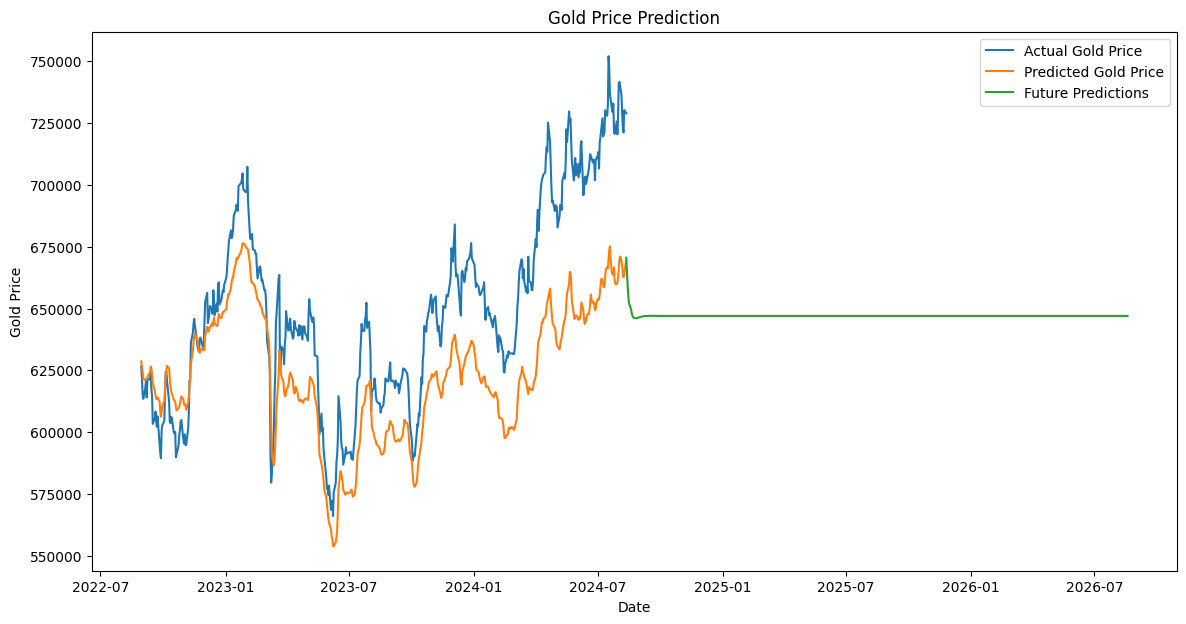

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
df = pd.read_csv('df_interpolated (1).csv')  # Update with your dataset path
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

# Select relevant columns, exclude 'date' for scaling
columns = ['gold_price_usd', 'silver_price', 's&p_500_index', 'nyse_com_index', 'usd_selling_exrate', 'gold_lkr']
data = df[columns].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define window size for LSTM
window_size = 30

# Create sequences
X, y = [], []
for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i-window_size:i, :])
    y.append(scaled_data[i, -1])  # 'gold_lkr' is the last column

X, y = np.array(X), np.array(y)

# Split data into train and test sets
split = int(0.8 * len(data))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=1)

# Make predictions
predictions = model.predict(X_test)

# Inverse scaling for predictions and actual values
predictions = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], predictions), axis=1))[:, -1]
actual_values = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_test.reshape(-1, 1)), axis=1))[:, -1]

# Generate future dates
last_date = df['date'].iloc[-1]
future_dates = pd.date_range(start=last_date, periods=len(predictions), freq='B')  # Business days

# Prepare data for future predictions
future_predictions = []
last_sequence = scaled_data[-window_size:]

for date in future_dates:
    prediction = model.predict(last_sequence[np.newaxis, :, :])[0, 0]
    future_predictions.append(prediction)
    new_sequence = np.append(last_sequence[1:], np.expand_dims(np.append(last_sequence[-1, :-1], prediction), axis=0), axis=0)
    last_sequence = new_sequence

# Inverse scaling for future predictions
future_predictions = scaler.inverse_transform(np.concatenate((np.tile(scaled_data[-1, :-1], (len(future_predictions), 1)), np.array(future_predictions).reshape(-1, 1)), axis=1))[:, -1]

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(df['date'][split+window_size:], actual_values, label='Actual Gold Price')
plt.plot(df['date'][split+window_size:], predictions, label='Predicted Gold Price')
plt.plot(future_dates, future_predictions, label='Future Predictions')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.title('Gold Price Prediction')
plt.legend()
plt.show()


## Code 02

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0066 - val_loss: 0.0269
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.6528e-04 - val_loss: 0.0122
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.6604e-04 - val_loss: 0.0162
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.1299e-04 - val_loss: 0.0106
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.9608e-04 - val_loss: 0.0169
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.1520e-04 - val_loss: 0.0105
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.5795e-04 - val_loss: 0.0156
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.4330e-04 - val_loss: 0.0145
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.6744e-04 - val_loss: 0.0160
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.5528e-04 - val_loss: 0.0162
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.6066e-04 - val_loss: 0.0150
Epoch 12/100

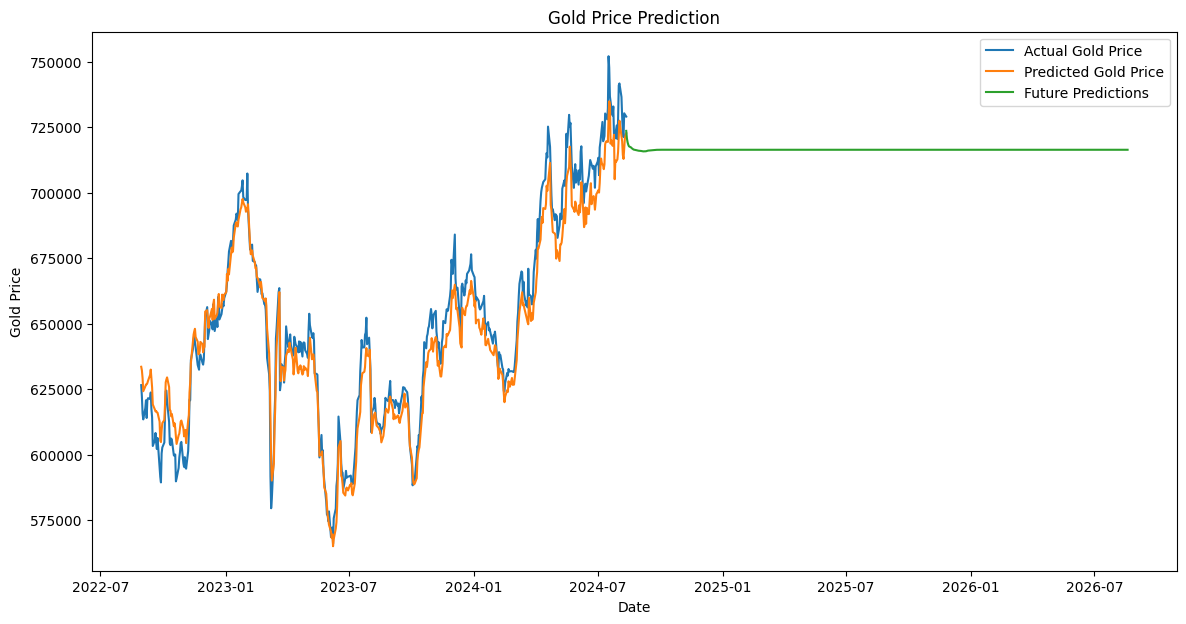

In [14]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import MinMaxScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping
# from sklearn.metrics import mean_squared_error

# # Load the dataset
# df = pd.read_csv('df_interpolated (1).csv')  # Update with your dataset path
# df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

# # Select relevant columns, exclude 'date' for scaling
# columns = ['gold_price_usd', 'silver_price', 's&p_500_index', 'nyse_com_index', 'usd_selling_exrate', 'gold_lkr']
# data = df[columns].values

# # Normalize the data
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_data = scaler.fit_transform(data)

# # Define window size for LSTM
# window_size = 30

# # Create sequences
# X, y = [], []
# for i in range(window_size, len(scaled_data)):
#     X.append(scaled_data[i-window_size:i, :])
#     y.append(scaled_data[i, -1])  # 'gold_lkr' is the last column

# X, y = np.array(X), np.array(y)

# # Split data into train and test sets
# split = int(0.8 * len(data))
# X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

# # Build LSTM model
# model = Sequential()
# model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dropout(0.2))
# model.add(LSTM(units=100))
# model.add(Dropout(0.2))
# model.add(Dense(units=1))

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Define early stopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# # Train the model
# history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=1)

# # Make predictions
# predictions = model.predict(X_test)

# # Inverse scaling for predictions and actual values
# X_test_inverse = np.concatenate((X_test[:, -1, :-1], y_test.reshape(-1, 1)), axis=1)
# predictions = np.concatenate((X_test[:, -1, :-1], predictions), axis=1)
# actual_values = scaler.inverse_transform(X_test_inverse)[:, -1]
# predictions = scaler.inverse_transform(predictions)[:, -1]

# # Calculate performance metrics
# mse = mean_squared_error(actual_values, predictions)
# print(f'Mean Squared Error: {mse}')

# # Generate future dates
# last_date = df['date'].iloc[-1]
# future_dates = pd.date_range(start=last_date, periods=len(predictions), freq='B')  # Business days

# # Prepare data for future predictions
# future_predictions = []
# last_sequence = scaled_data[-window_size:]

# for date in future_dates:
#     prediction = model.predict(last_sequence[np.newaxis, :, :])[0, 0]
#     future_predictions.append(prediction)
#     new_sequence = np.append(last_sequence[1:], np.expand_dims(np.append(last_sequence[-1, :-1], prediction), axis=0), axis=0)
#     last_sequence = new_sequence

# # Inverse scaling for future predictions
# future_predictions = scaler.inverse_transform(np.concatenate((np.tile(scaled_data[-1, :-1], (len(future_predictions), 1)), np.array(future_predictions).reshape(-1, 1)), axis=1))[:, -1]

# # Plot results
# plt.figure(figsize=(14, 7))
# plt.plot(df['date'][split+window_size:], actual_values, label='Actual Gold Price')
# plt.plot(df['date'][split+window_size:], predictions, label='Predicted Gold Price')
# plt.plot(future_dates, future_predictions, label='Future Predictions')
# plt.xlabel('Date')
# plt.ylabel('Gold Price')
# plt.title('Gold Price Prediction')
# plt.legend()
# plt.show()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Attention, Concatenate, Input, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

# Load the dataset
df = pd.read_csv('df_interpolated (1).csv')  # Update with your dataset path
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

# Select relevant columns, exclude 'date' for scaling
columns = ['gold_price_usd', 'silver_price', 's&p_500_index', 'nyse_com_index', 'usd_selling_exrate', 'gold_lkr']
data = df[columns].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define window size for GRU
window_size = 30

# Create sequences
X, y = [], []
for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i-window_size:i, :])
    y.append(scaled_data[i, -1])  # 'gold_lkr' is the last column

X, y = np.array(X), np.array(y)

# Split data into train and test sets
split = int(0.8 * len(data))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

# Define the GRU model with attention
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
gru_layer = GRU(units=100, return_sequences=True)(input_layer)
attention = Attention()([gru_layer, gru_layer])
concat = Concatenate()([gru_layer, attention])
gru_output = GRU(units=100)(concat)
dropout_layer = Dropout(0.2)(gru_output)
output_layer = Dense(units=1)(dropout_layer)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=1)

# Make predictions
predictions = model.predict(X_test)

# Inverse scaling for predictions and actual values
X_test_inverse = np.concatenate((X_test[:, -1, :-1], y_test.reshape(-1, 1)), axis=1)
predictions = np.concatenate((X_test[:, -1, :-1], predictions), axis=1)
actual_values = scaler.inverse_transform(X_test_inverse)[:, -1]
predictions = scaler.inverse_transform(predictions)[:, -1]

# Calculate performance metrics
mse = mean_squared_error(actual_values, predictions)
print(f'Mean Squared Error: {mse}')

# Generate future dates
last_date = df['date'].iloc[-1]
future_dates = pd.date_range(start=last_date, periods=len(predictions), freq='B')  # Business days

# Prepare data for future predictions
future_predictions = []
last_sequence = scaled_data[-window_size:]

for date in future_dates:
    prediction = model.predict(last_sequence[np.newaxis, :, :])[0, 0]
    future_predictions.append(prediction)
    new_sequence = np.append(last_sequence[1:], np.expand_dims(np.append(last_sequence[-1, :-1], prediction), axis=0), axis=0)
    last_sequence = new_sequence

# Inverse scaling for future predictions
future_predictions = scaler.inverse_transform(np.concatenate((np.tile(scaled_data[-1, :-1], (len(future_predictions), 1)), np.array(future_predictions).reshape(-1, 1)), axis=1))[:, -1]

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(df['date'][split+window_size:], actual_values, label='Actual Gold Price')
plt.plot(df['date'][split+window_size:], predictions, label='Predicted Gold Price')
plt.plot(future_dates, future_predictions, label='Future Predictions')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.title('Gold Price Prediction')
plt.legend()
plt.show()



Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0069 - val_loss: 0.0350
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.7075e-04 - val_loss: 0.0250
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.2295e-04 - val_loss: 0.0274
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.7860e-04 - val_loss: 0.0204
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.1356e-04 - val_loss: 0.0244
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.8110e-04 - val_loss: 0.0204
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.7162e-04 - val_loss: 0.0199
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.6176e-04 - val_loss: 0.0237
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.0358e-04 - val_loss: 0.0164
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.0235e-04 - val_loss: 0.0157
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.0691e-04 - val_loss: 0.0133
Epoch 12/100

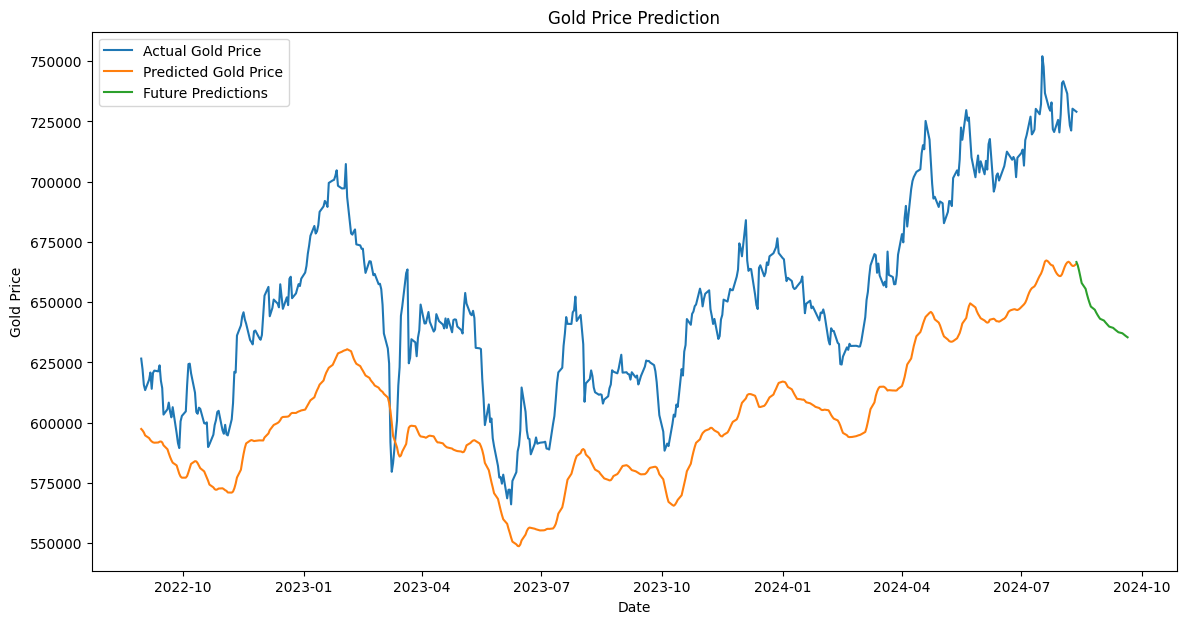

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Attention, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

# Load the dataset
df = pd.read_csv('df_interpolated (1).csv')  # Update with your dataset path
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

# Select relevant columns, exclude 'date' for scaling
columns = ['gold_price_usd', 'silver_price', 's&p_500_index', 'nyse_com_index', 'usd_selling_exrate', 'gold_lkr']
data = df[columns].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define window size for LSTM
window_size = 30

# Create sequences
X, y = [], []
for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i-window_size:i, :])
    y.append(scaled_data[i, -1])  # 'gold_lkr' is the last column

X, y = np.array(X), np.array(y)

# Split data into train and test sets
split = int(0.8 * len(data))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

# Define the LSTM model with attention
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# LSTM layers
lstm_out = LSTM(units=100, return_sequences=True)(input_layer)
lstm_out = Dropout(0.2)(lstm_out)
attention = Attention()([lstm_out, lstm_out])
concat = Concatenate()([lstm_out, attention])
lstm_out = LSTM(units=100)(concat)
lstm_out = Dropout(0.2)(lstm_out)
output_layer = Dense(units=1)(lstm_out)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=1)

# Make predictions
predictions = model.predict(X_test)

# Inverse scaling for predictions and actual values
X_test_inverse = np.concatenate((X_test[:, -1, :-1], y_test.reshape(-1, 1)), axis=1)
predictions = np.concatenate((X_test[:, -1, :-1], predictions), axis=1)
actual_values = scaler.inverse_transform(X_test_inverse)[:, -1]
predictions = scaler.inverse_transform(predictions)[:, -1]

# Calculate performance metrics
mse = mean_squared_error(actual_values, predictions)
print(f'Mean Squared Error: {mse}')

# Generate future dates
last_date = df['date'].iloc[-1]
future_dates = pd.date_range(start=last_date, periods=30, freq='B')  # Business days for 30 days

# Prepare data for future predictions
future_predictions = []
last_sequence = scaled_data[-window_size:]

for date in future_dates:
    prediction = model.predict(last_sequence[np.newaxis, :, :])[0, 0]
    future_predictions.append(prediction)
    new_sequence = np.append(last_sequence[1:], np.expand_dims(np.append(last_sequence[-1, :-1], prediction), axis=0), axis=0)
    last_sequence = new_sequence

# Inverse scaling for future predictions
future_predictions = scaler.inverse_transform(np.concatenate((np.tile(scaled_data[-1, :-1], (len(future_predictions), 1)), np.array(future_predictions).reshape(-1, 1)), axis=1))[:, -1]

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(df['date'][split+window_size:], actual_values, label='Actual Gold Price')
plt.plot(df['date'][split+window_size:], predictions, label='Predicted Gold Price')
plt.plot(future_dates, future_predictions, label='Future Predictions')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.title('Gold Price Prediction')
plt.legend()
plt.show()


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Attention, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import optuna

# Load the dataset
df = pd.read_csv('df_interpolated (1).csv')  # Update with your dataset path
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

# Select relevant columns, exclude 'date' for scaling
columns = ['gold_price_usd', 'silver_price', 's&p_500_index', 'nyse_com_index', 'usd_selling_exrate', 'gold_lkr']
data = df[columns].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define window size for LSTM
window_size = 30

# Create sequences
X, y = [], []
for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i-window_size:i, :])
    y.append(scaled_data[i, -1])  # 'gold_lkr' is the last column

X, y = np.array(X), np.array(y)

# Split data into train and test sets
split = int(0.8 * len(data))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

# Define the model with LSTM and Attention
def create_model(n_layers, units):
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # LSTM layers
    lstm_out = LSTM(units=units, return_sequences=True)(input_layer)
    lstm_out = Dropout(0.2)(lstm_out)
    for _ in range(n_layers - 1):
        lstm_out = LSTM(units=units, return_sequences=True)(lstm_out)
        lstm_out = Dropout(0.2)(lstm_out)
    attention = Attention()([lstm_out, lstm_out])
    concat = Concatenate()([lstm_out, attention])
    lstm_out = LSTM(units=units)(concat)
    lstm_out = Dropout(0.2)(lstm_out)
    output_layer = Dense(units=1)(lstm_out)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Objective function for Optuna
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 4)
    units = trial.suggest_int('units', 50, 200)
    
    model = create_model(n_layers, units)
    
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=0)
    val_loss = min(history.history['val_loss'])
    
    return val_loss

# Optimize hyperparameters using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print(f'Best parameters: {study.best_params}')

# Build and train the final model with the best parameters
best_n_layers = study.best_params['n_layers']
best_units = study.best_params['units']

model = create_model(best_n_layers, best_units)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=1)

# Make predictions
predictions = model.predict(X_test)

# Inverse scaling for predictions and actual values
X_test_inverse = np.concatenate((X_test[:, -1, :-1], y_test.reshape(-1, 1)), axis=1)
predictions = np.concatenate((X_test[:, -1, :-1], predictions), axis=1)
actual_values = scaler.inverse_transform(X_test_inverse)[:, -1]
predictions = scaler.inverse_transform(predictions)[:, -1]

# Calculate performance metrics
mse = mean_squared_error(actual_values, predictions)
print(f'Mean Squared Error: {mse}')

# Generate future dates
last_date = df['date'].iloc[-1]
future_dates = pd.date_range(start=last_date, periods=30, freq='B')  # Business days for 30 days

# Prepare data for future predictions
future_predictions = []
last_sequence = scaled_data[-window_size:]

for date in future_dates:
    prediction = model.predict(last_sequence[np.newaxis, :, :])[0, 0]
    future_predictions.append(prediction)
    new_sequence = np.append(last_sequence[1:], np.expand_dims(np.append(last_sequence[-1, :-1], prediction), axis=0), axis=0)
    last_sequence = new_sequence

# Inverse scaling for future predictions
future_predictions = scaler.inverse_transform(np.concatenate((np.tile(scaled_data[-1, :-1], (len(future_predictions), 1)), np.array(future_predictions).reshape(-1, 1)), axis=1))[:, -1]

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(df['date'][split+window_size:], actual_values, label='Actual Gold Price')
plt.plot(df['date'][split+window_size:], predictions, label='Predicted Gold Price')
plt.plot(future_dates, future_predictions, label='Future Predictions')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.title('Gold Price Prediction')
plt.legend()
plt.show()


[I 2024-09-11 15:53:52,679] A new study created in memory with name: no-name-18d95c1f-9ea8-449c-9c36-176cf73cffb4
[W 2024-09-11 15:53:52,731] Trial 0 failed with parameters: {'n_layers': 4, 'units': 72} because of the following error: NameError("name 'Model' is not defined").
Traceback (most recent call last):
  File "C:\Users\User\AppData\Roaming\Python\Python310\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_5364\3821201569.py", line 63, in objective
    model = create_model(n_layers, units)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_5364\3821201569.py", line 54, in create_model
    model = Model(inputs=input_layer, outputs=output_layer)
NameError: name 'Model' is not defined
[W 2024-09-11 15:53:52,732] Trial 0 failed with value None.


NameError: name 'Model' is not defined

## 2222222222222222222222222222222222

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-09-12 10:21:50,907] A new study created in memory with name: no-name-402358cc-b5f3-4902-b5a9-bfac9e12725d
[I 2024-09-12 10:23:25,234] Trial 0 finished with value: 0.012203404679894447 and parameters: {'n_layers': 3, 'units': 116}. Best is trial 0 with value: 0.012203404679894447.
[I 2024-09-12 10:27:49,824] Trial 1 finished with value: 0.011232800781726837 and parameters: {'n_layers': 4, 'units': 149}. Best is trial 1 with value: 0.011232800781726837.
[I 2024-09-12 10:29:14,095] Trial 2 finished with value: 0.021840374916791916 and parameters: {'n_layers': 4, 'units': 81}. Best is trial 1 with value: 0.011232800781726837.
[I 2024-09-12 10:31:09,803] Trial 3 finished with value: 0.005126390140503645 and parameters: {'

Best parameters: {'n_layers': 1, 'units': 200}
Epoch 1/100
63/63 [==============================] - 22s 262ms/step - loss: 0.0059 - val_loss: 0.0379
Epoch 2/100
63/63 [==============================] - 14s 227ms/step - loss: 2.6751e-04 - val_loss: 0.0318
Epoch 3/100
63/63 [==============================] - 14s 228ms/step - loss: 2.0852e-04 - val_loss: 0.0255
Epoch 4/100
63/63 [==============================] - 15s 235ms/step - loss: 1.8316e-04 - val_loss: 0.0277
Epoch 5/100
63/63 [==============================] - 15s 237ms/step - loss: 1.6985e-04 - val_loss: 0.0211
Epoch 6/100
63/63 [==============================] - 15s 231ms/step - loss: 1.9227e-04 - val_loss: 0.0201
Epoch 7/100
63/63 [==============================] - 15s 238ms/step - loss: 1.6700e-04 - val_loss: 0.0211
Epoch 8/100
63/63 [==============================] - 15s 230ms/step - loss: 1.5347e-04 - val_loss: 0.0152
Epoch 9/100
63/63 [==============================] - 15s 236ms/step - loss: 1.7078e-04 - val_loss: 0.0083
Epo

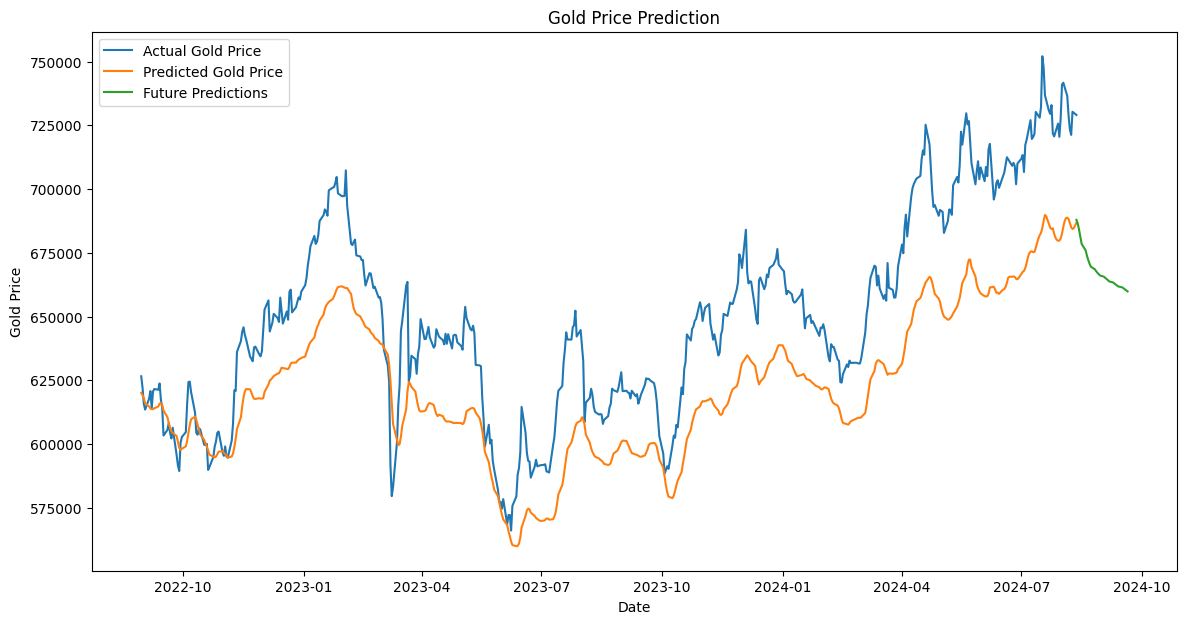

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Attention, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import optuna

# Load the dataset
df = pd.read_csv('df_interpolated (1).csv')  # Update with your dataset path
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

# Select relevant columns, exclude 'date' for scaling
columns = ['gold_price_usd', 'silver_price', 's&p_500_index', 'nyse_com_index', 'usd_selling_exrate', 'gold_lkr']
data = df[columns].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define window size for LSTM
window_size = 30

# Create sequences
X, y = [], []
for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i-window_size:i, :])
    y.append(scaled_data[i, -1])  # 'gold_lkr' is the last column

X, y = np.array(X), np.array(y)

# Split data into train and test sets
split = int(0.8 * len(data))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

# Define the model with LSTM and Attention
def create_model(n_layers, units):
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # LSTM layers
    lstm_out = LSTM(units=units, return_sequences=True)(input_layer)
    lstm_out = Dropout(0.2)(lstm_out)
    for _ in range(n_layers - 1):
        lstm_out = LSTM(units=units, return_sequences=True)(lstm_out)
        lstm_out = Dropout(0.2)(lstm_out)
    attention = Attention()([lstm_out, lstm_out])
    concat = Concatenate()([lstm_out, attention])
    lstm_out = LSTM(units=units)(concat)
    lstm_out = Dropout(0.2)(lstm_out)
    output_layer = Dense(units=1)(lstm_out)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Objective function for Optuna
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 4)
    units = trial.suggest_int('units', 50, 200)
    
    model = create_model(n_layers, units)
    
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=0)
    val_loss = min(history.history['val_loss'])
    
    return val_loss

# Optimize hyperparameters using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print(f'Best parameters: {study.best_params}')

# Build and train the final model with the best parameters
best_n_layers = study.best_params['n_layers']
best_units = study.best_params['units']

model = create_model(best_n_layers, best_units)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=1)

# Make predictions
predictions = model.predict(X_test)

# Inverse scaling for predictions and actual values
X_test_inverse = np.concatenate((X_test[:, -1, :-1], y_test.reshape(-1, 1)), axis=1)
predictions = np.concatenate((X_test[:, -1, :-1], predictions), axis=1)
actual_values = scaler.inverse_transform(X_test_inverse)[:, -1]
predictions = scaler.inverse_transform(predictions)[:, -1]

# Calculate performance metrics
mse = mean_squared_error(actual_values, predictions)
print(f'Mean Squared Error: {mse}')

# Generate future dates
last_date = df['date'].iloc[-1]
future_dates = pd.date_range(start=last_date, periods=30, freq='B')  # Business days for 30 days

# Prepare data for future predictions
future_predictions = []
last_sequence = scaled_data[-window_size:]

for date in future_dates:
    prediction = model.predict(last_sequence[np.newaxis, :, :])[0, 0]
    future_predictions.append(prediction)
    new_sequence = np.append(last_sequence[1:], np.expand_dims(np.append(last_sequence[-1, :-1], prediction), axis=0), axis=0)
    last_sequence = new_sequence

# Inverse scaling for future predictions
future_predictions = scaler.inverse_transform(np.concatenate((np.tile(scaled_data[-1, :-1], (len(future_predictions), 1)), np.array(future_predictions).reshape(-1, 1)), axis=1))[:, -1]

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(df['date'][split+window_size:], actual_values, label='Actual Gold Price')
plt.plot(df['date'][split+window_size:], predictions, label='Predicted Gold Price')
plt.plot(future_dates, future_predictions, label='Future Predictions')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.title('Gold Price Prediction')
plt.legend()
plt.show()


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Attention, Concatenate, Add
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
import optuna

# Load the dataset
df = pd.read_csv('df_interpolated (1).csv')  # Update with your dataset path
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

# Select relevant columns, exclude 'date' for scaling
columns = ['gold_price_usd', 'silver_price', 's&p_500_index', 'nyse_com_index', 'usd_selling_exrate', 'gold_lkr']
data = df[columns].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define window size for LSTM
window_size = 30

# Create sequences
X, y = [], []
for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i-window_size:i, :])
    y.append(scaled_data[i, -1])  # 'gold_lkr' is the last column

X, y = np.array(X), np.array(y)

# Split data into train and test sets
split = int(0.8 * len(data))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

# Define the model with LSTM, Attentionid, and Dropout
def create_model(n_layers, units, dropout_rate, learning_rate):
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # LSTM layers
    lstm_out = LSTM(units=units, return_sequences=True)(input_layer)
    lstm_out = Dropout(dropout_rate)(lstm_out)
    for _ in range(n_layers - 1):
        lstm_out = LSTM(units=units, return_sequences=True)(lstm_out)
        lstm_out = Dropout(dropout_rate)(lstm_out)
    attention = Attention()([lstm_out, lstm_out])
    concat = Concatenate()([lstm_out, attention])
    lstm_out = LSTM(units=units)(concat)
    lstm_out = Dropout(dropout_rate)(lstm_out)
    output_layer = Dense(units=1)(lstm_out)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Objective function for Optuna
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 4)
    units = trial.suggest_int('units', 50, 200)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    
    model = create_model(n_layers, units, dropout_rate, learning_rate)
    
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=0)
    val_loss = min(history.history['val_loss'])
    
    return val_loss

# Optimize hyperparameters using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print(f'Best parameters: {study.best_params}')

# Build and train the final model with the best parameters
best_n_layers = study.best_params['n_layers']
best_units = study.best_params['units']
best_dropout_rate = study.best_params['dropout_rate']
best_learning_rate = study.best_params['learning_rate']

model = create_model(best_n_layers, best_units, best_dropout_rate, best_learning_rate)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=1)

# Make predictions
predictions = model.predict(X_test)

# Inverse scaling for predictions and actual values
X_test_inverse = np.concatenate((X_test[:, -1, :-1], y_test.reshape(-1, 1)), axis=1)
predictions = np.concatenate((X_test[:, -1, :-1], predictions), axis=1)
actual_values = scaler.inverse_transform(X_test_inverse)[:, -1]
predictions = scaler.inverse_transform(predictions)[:, -1]

# Calculate performance metrics
mse = mean_squared_error(actual_values, predictions)
print(f'Mean Squared Error: {mse}')

# Generate future dates
last_date = df['date'].iloc[-1]
future_dates = pd.date_range(start=last_date, periods=30, freq='B')  # Business days for 30 days

# Prepare data for future predictions
future_predictions = []
last_sequence = scaled_data[-window_size:]

for date in future_dates:
    prediction = model.predict(last_sequence[np.newaxis, :, :])[0, 0]
    future_predictions.append(prediction)
    new_sequence = np.append(last_sequence[1:], np.expand_dims(np.append(last_sequence[-1, :-1], prediction), axis=0), axis=0)
    last_sequence = new_sequence

# Inverse scaling for future predictions
future_predictions = scaler.inverse_transform(np.concatenate((np.tile(scaled_data[-1, :-1], (len(future_predictions), 1)), np.array(future_predictions).reshape(-1, 1)), axis=1))[:, -1]

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(df['date'][split+window_size:], actual_values, label='Actual Gold Price')
plt.plot(df['date'][split+window_size:], predictions, label='Predicted Gold Price')
plt.plot(future_dates, future_predictions, label='Future Predictions')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.title('Gold Price Prediction')
plt.legend()
plt.show()


C:\Users\User\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-09-13 11:14:45,629] A new study created in memory with name: no-name-5f891fcc-95c8-4696-a7bc-76acbe392b0d
C:\Users\User\AppData\Local\Temp\ipykernel_10084\4083878375.py:64: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-09-13 11:16:15,628] Trial 0 finished with value: 0.013918081298470497 and parameters: {'n_layers': 3, 'units': 82, 'dropout_rate': 0.19129154985553606, 'learning_rate': 0.0005545729887004082}. Best is trial 0 with value: 0.013918081298470497.
[I 2024-09-13 11:17:17,47

KeyboardInterrupt: 